# Data and Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

In [3]:
aug_speeds = {"keyboard": 117, "char_substitute": 109, "char_insert": 109, "char_swap": 114,
              "ocr": 114, "char_delete": 108,
              "word_insert": 0.0, "word_substitute": 0.0, "text_rotate": 32,
              "stopword_insert": 34, "word_join": 32, "word_cutout": 36,
              "w2v_insert": 0.0, "w2v_substitute": 0.0, 
              "fasttext": 137, "glove_twitter": 88, "glove_wiki": 82, "word2vec": 137,
              "synonym": 522, "split": 110, "sentence_shuffle": 67, "one_third_cut": 0.0, "half_cut":0.0}


- What Augs are useful
- What Text models perform best

In [4]:


choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.3, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.5, "sentence_shuffle": 0.5, "one_third_cut": 0.3, "half_cut":0.1}
preprocess_text = TextAugment([0.05, 0.05, 0.05, 0.35, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# images = list(data["train"].img) + list(data["test"].img)
# pd.DataFrame({"img":images}).to_csv("image.csv", header=None, index=None)

# ImageAugment([0.2, 0.5, 0.3])


In [5]:
# data["train"].label.value_counts()
# train = data["train"]

# ones = train[train["label"] == 1]
# zeros = train[train["label"] == 0].sample(n=len(ones), replace=False)
# data["train"] = pd.concat((ones, zeros)).sample(frac=1.0)
# data["train"].label.value_counts()

# len(set(data["train"]["id"])) == data["train"].shape[0]


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Params

In [6]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




In [7]:
batch_size=256
epochs = 10
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()



# BERT Models

## Non Ensemble

## Head Ensemble

## Decoder Ensemble

Pick stored Model ./distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 1.051853 LR = 0.00000348



Epoch =  2 Loss = 0.738276 LR = 0.00000697



Epoch =  3 Loss = 0.657239 LR = 0.00001045



Epoch =  4 Loss = 0.618268 LR = 0.00001393


Proba       Preds    
         min   max   min max
Labels                      
0      0.308 0.481     0   0
1      0.309 0.481     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.337,"[0.6630071401596069, 0.33699291944503784]",0,0,0.417,"[0.5827391147613525, 0.4172608256340027]",0,0,0.415,"[0.5848576426506042, 0.41514235734939575]",0,0
1,0.444,"[0.5557489991188049, 0.44425103068351746]",0,1,0.365,"[0.6352814435958862, 0.36471855640411377]",0,0,0.395,"[0.6046959757804871, 0.39530402421951294]",0,1
2,0.439,"[0.560946524143219, 0.439053475856781]",0,1,0.404,"[0.5957981944084167, 0.40420177578926086]",0,0,0.361,"[0.6389980316162109, 0.36100196838378906]",0,0
3,0.389,"[0.6110917329788208, 0.3889082670211792]",0,0,0.350,"[0.6501692533493042, 0.3498307466506958]",0,0,0.341,"[0.6586617827415466, 0.34133821725845337]",0,1
4,0.394,"[0.6056069731712341, 0.39439302682876587]",0,1,0.379,"[0.6214465498924255, 0.3785533905029297]",0,1,0.412,"[0.5875474810600281, 0.4124525487422943]",0,0


scores =  {'map': '0.5582', 'acc': '0.5000', 'auc': '0.5741'}
Epoch =  4 Train = 0.615778 Val = 0.574056



Epoch =  5 Loss = 0.593918 LR = 0.00001742



Epoch =  6 Loss = 0.567713 LR = 0.00002090



Epoch =  7 Loss = 0.565391 LR = 0.00002439


Proba       Preds    
         min   max   min max
Labels                      
0      0.321 0.559     0   1
1      0.341 0.553     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.451,"[0.5489124655723572, 0.4510875344276428]",0,0,0.446,"[0.5536649823188782, 0.4463350176811218]",0,1,0.415,"[0.5847676396369934, 0.4152323603630066]",0,0
1,0.409,"[0.5905364751815796, 0.40946346521377563]",0,0,0.371,"[0.6290110349655151, 0.3709889352321625]",0,0,0.379,"[0.6205970048904419, 0.3794029951095581]",0,0
2,0.553,"[0.44676023721694946, 0.5532397627830505]",1,1,0.387,"[0.6125742197036743, 0.3874257206916809]",0,1,0.368,"[0.6317980885505676, 0.3682019114494324]",0,1
3,0.420,"[0.5796840190887451, 0.4203159809112549]",0,1,0.450,"[0.5504130125045776, 0.44958698749542236]",0,1,0.399,"[0.601169228553772, 0.3988308310508728]",0,0
4,0.445,"[0.5547811388969421, 0.44521886110305786]",0,0,0.461,"[0.5391180515289307, 0.46088194847106934]",0,1,0.365,"[0.6349801421165466, 0.36501985788345337]",0,0


scores =  {'map': '0.5839', 'acc': '0.5180', 'auc': '0.5944'}
Epoch =  7 Train = 0.660749 Val = 0.594424



Epoch =  8 Loss = 0.535793 LR = 0.00002787



Epoch =  9 Loss = 0.523511 LR = 0.00003135


Proba       Preds    
         min   max   min max
Labels                      
0      0.195 0.657     0   1
1      0.225 0.657     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.350,"[0.6503586173057556, 0.3496413826942444]",0,0,0.424,"[0.5758065581321716, 0.42419344186782837]",0,0,0.391,"[0.6086961030960083, 0.3913038671016693]",0,1
1,0.318,"[0.6821247339248657, 0.3178752660751343]",0,1,0.431,"[0.568637490272522, 0.4313625395298004]",0,1,0.504,"[0.49619123339653015, 0.5038087368011475]",1,0
2,0.560,"[0.4401123523712158, 0.5598876476287842]",1,0,0.504,"[0.49586379528045654, 0.5041362047195435]",1,0,0.475,"[0.5254305601119995, 0.4745694398880005]",0,1
3,0.354,"[0.6455656886100769, 0.3544343113899231]",0,1,0.271,"[0.7285750508308411, 0.27142494916915894]",0,1,0.271,"[0.7294381260871887, 0.2705618739128113]",0,0
4,0.451,"[0.5490074753761292, 0.4509925842285156]",0,1,0.363,"[0.6371575593948364, 0.3628424108028412]",0,0,0.577,"[0.42269885540008545, 0.5773011445999146]",1,1


scores =  {'map': '0.6048', 'acc': '0.5460', 'auc': '0.6160'}
Epoch =  9 Train = 0.715903 Val = 0.615992



Epoch =  10 Loss = 0.513766 LR = 0.00003484



Epoch =  11 Loss = 0.498904 LR = 0.00003832


Proba       Preds    
         min   max   min max
Labels                      
0      0.243 0.700     0   1
1      0.313 0.704     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.493,"[0.5070340633392334, 0.492965966463089]",0,0,0.679,"[0.3210263252258301, 0.6789736151695251]",1,1,0.347,"[0.6525328159332275, 0.34746718406677246]",0,0
1,0.528,"[0.47207701206207275, 0.5279229879379272]",1,0,0.500,"[0.49975016713142395, 0.5002498626708984]",1,1,0.366,"[0.6335016489028931, 0.36649835109710693]",0,1
2,0.533,"[0.46728992462158203, 0.532710075378418]",1,1,0.482,"[0.5177698731422424, 0.48223012685775757]",0,1,0.394,"[0.605544924736023, 0.39445507526397705]",0,1
3,0.516,"[0.48373907804489136, 0.5162608623504639]",1,1,0.646,"[0.35374993085861206, 0.6462500691413879]",1,1,0.552,"[0.4481889009475708, 0.5518110990524292]",1,1
4,0.520,"[0.4797581434249878, 0.5202418565750122]",1,1,0.397,"[0.6032840013504028, 0.39671602845191956]",0,1,0.450,"[0.5495913624763489, 0.4504086673259735]",0,1


scores =  {'map': '0.6108', 'acc': '0.5980', 'auc': '0.6306'}
Epoch =  11 Train = 0.750708 Val = 0.630616



Epoch =  12 Loss = 0.477718 LR = 0.00004180



Epoch =  13 Loss = 0.478759 LR = 0.00004529


Exception for:  keyboard | '' '' | ['half_cut' 'word_cutout' 'text_rotate' 'keyboard' 'char_insert'] argument of type 'NoneType' is not iterable

Epoch =  14 Loss = 0.468934 LR = 0.00004877


Proba       Preds    
         min   max   min max
Labels                      
0      0.147 0.579     0   1
1      0.194 0.579     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.545,"[0.45517393946647644, 0.544826090335846]",1,1,0.280,"[0.7199515104293823, 0.28004851937294006]",0,1,0.383,"[0.6165544986724854, 0.3834455609321594]",0,0
1,0.340,"[0.6596899032592773, 0.34031006693840027]",0,1,0.229,"[0.7706440687179565, 0.22935587167739868]",0,0,0.444,"[0.5563223361968994, 0.4436776638031006]",0,1
2,0.498,"[0.5019938349723816, 0.4980061948299408]",0,1,0.404,"[0.5963394641876221, 0.40366047620773315]",0,1,0.297,"[0.7026238441467285, 0.29737618565559387]",0,0
3,0.231,"[0.7688906192779541, 0.2311094105243683]",0,0,0.284,"[0.7164777517318726, 0.28352227807044983]",0,0,0.405,"[0.5945885181427002, 0.4054114818572998]",0,0
4,0.319,"[0.6811516284942627, 0.3188483715057373]",0,0,0.507,"[0.49320513010025024, 0.5067949295043945]",1,0,0.348,"[0.651970386505127, 0.34802964329719543]",0,0


scores =  {'map': '0.6002', 'acc': '0.5160', 'auc': '0.6393'}
Epoch =  14 Train = 0.771606 Val = 0.639336



Epoch =  15 Loss = 0.469757 LR = 0.00004995



Epoch =  16 Loss = 0.452597 LR = 0.00004970



Epoch =  17 Loss = 0.446933 LR = 0.00004924


Proba       Preds    
         min   max   min max
Labels                      
0      0.162 0.677     0   1
1      0.212 0.677     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.312,"[0.6877903342247009, 0.3122096657752991]",0,0,0.414,"[0.5863629579544067, 0.4136370122432709]",0,1,0.352,"[0.6479834318161011, 0.3520166277885437]",0,0
1,0.354,"[0.6462242603302002, 0.3537757396697998]",0,0,0.256,"[0.7437399625778198, 0.25626009702682495]",0,1,0.536,"[0.4641304016113281, 0.5358695983886719]",1,1
2,0.311,"[0.6886029839515686, 0.3113970160484314]",0,0,0.334,"[0.6656956672668457, 0.3343043923377991]",0,1,0.210,"[0.7897200584411621, 0.2102799266576767]",0,0
3,0.566,"[0.4340125322341919, 0.5659874677658081]",1,1,0.414,"[0.5859931707382202, 0.4140068292617798]",0,1,0.390,"[0.6096912622451782, 0.390308678150177]",0,0
4,0.540,"[0.4598747491836548, 0.5401252508163452]",1,0,0.307,"[0.6926097869873047, 0.3073902130126953]",0,1,0.388,"[0.6122149229049683, 0.38778507709503174]",0,1


scores =  {'map': '0.6123', 'acc': '0.5520', 'auc': '0.6377'}
Epoch =  17 Train = 0.785311 Val = 0.637688



Epoch =  18 Loss = 0.440162 LR = 0.00004856



Epoch =  19 Loss = 0.435285 LR = 0.00004768


Proba       Preds    
         min   max   min max
Labels                      
0      0.153 0.654     0   1
1      0.192 0.654     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.253,"[0.7467626333236694, 0.25323739647865295]",0,1,0.366,"[0.6344874501228333, 0.3655126094818115]",0,0,0.447,"[0.5534436702728271, 0.44655632972717285]",0,1
1,0.326,"[0.6735291481018066, 0.32647085189819336]",0,0,0.462,"[0.5384190082550049, 0.46158093214035034]",0,1,0.452,"[0.5483046174049377, 0.45169538259506226]",0,0
2,0.443,"[0.5567697882652283, 0.44323021173477173]",0,1,0.451,"[0.5489764213562012, 0.45102354884147644]",0,1,0.394,"[0.6056742668151855, 0.39432570338249207]",0,0
3,0.449,"[0.5511083602905273, 0.44889166951179504]",0,0,0.444,"[0.5559040904045105, 0.4440959095954895]",0,1,0.339,"[0.6611959934234619, 0.3388040065765381]",0,1
4,0.477,"[0.523296058177948, 0.476703941822052]",0,1,0.346,"[0.6542873382568359, 0.34571266174316406]",0,1,0.327,"[0.6728136539459229, 0.32718631625175476]",0,0


scores =  {'map': '0.6178', 'acc': '0.5540', 'auc': '0.6478'}
Epoch =  19 Train = 0.795327 Val = 0.647784



Epoch =  20 Loss = 0.435876 LR = 0.00004660



Epoch =  21 Loss = 0.431259 LR = 0.00004534



Epoch =  22 Loss = 0.421699 LR = 0.00004389



Epoch =  23 Loss = 0.423310 LR = 0.00004229


Proba       Preds    
         min   max   min max
Labels                      
0      0.084 0.672     0   1
1      0.137 0.681     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.201,"[0.7988682985305786, 0.20113176107406616]",0,0,0.343,"[0.6573496460914612, 0.3426503837108612]",0,0,0.154,"[0.8455678224563599, 0.15443220734596252]",0,0
1,0.229,"[0.770882785320282, 0.2291172295808792]",0,0,0.179,"[0.8213003277778625, 0.17869967222213745]",0,0,0.321,"[0.6787870526313782, 0.3212129473686218]",0,0
2,0.458,"[0.5418738126754761, 0.4581262469291687]",0,0,0.240,"[0.759553074836731, 0.24044694006443024]",0,0,0.406,"[0.5937387943267822, 0.4062612056732178]",0,1
3,0.553,"[0.4465070366859436, 0.5534929633140564]",1,0,0.359,"[0.6414932012557983, 0.35850685834884644]",0,1,0.479,"[0.5208696126937866, 0.4791303873062134]",0,1
4,0.585,"[0.4150697588920593, 0.5849303007125854]",1,0,0.485,"[0.5153441429138184, 0.48465588688850403]",0,1,0.607,"[0.3927389979362488, 0.6072610020637512]",1,1


scores =  {'map': '0.6245', 'acc': '0.5500', 'auc': '0.6543'}
Epoch =  23 Train = 0.810421 Val = 0.654344



Epoch =  24 Loss = 0.412697 LR = 0.00004053



Epoch =  25 Loss = 0.407716 LR = 0.00003863



Epoch =  26 Loss = 0.416006 LR = 0.00003662



Epoch =  27 Loss = 0.406221 LR = 0.00003450


Proba       Preds    
         min   max   min max
Labels                      
0      0.067 0.635     0   1
1      0.181 0.728     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.476,"[0.5235030651092529, 0.47649693489074707]",0,1,0.286,"[0.7142601013183594, 0.285739928483963]",0,0,0.417,"[0.5826002359390259, 0.4173997938632965]",0,0
1,0.333,"[0.6667842864990234, 0.3332156538963318]",0,0,0.362,"[0.6376436948776245, 0.3623563051223755]",0,1,0.273,"[0.7268615961074829, 0.2731384336948395]",0,0
2,0.411,"[0.5891205668449402, 0.4108794331550598]",0,0,0.487,"[0.512688934803009, 0.48731109499931335]",0,1,0.421,"[0.5794827342033386, 0.4205172657966614]",0,1
3,0.597,"[0.4025147259235382, 0.5974853038787842]",1,1,0.453,"[0.5466541051864624, 0.4533458650112152]",0,1,0.341,"[0.6588972806930542, 0.3411027193069458]",0,1
4,0.572,"[0.42815130949020386, 0.5718486905097961]",1,0,0.428,"[0.5719869136810303, 0.4280130863189697]",0,1,0.211,"[0.7888215780258179, 0.21117843687534332]",0,1


scores =  {'map': '0.6256', 'acc': '0.5400', 'auc': '0.6476'}
Epoch =  27 Train = 0.820141 Val = 0.647608



Epoch =  28 Loss = 0.403124 LR = 0.00003231



Epoch =  29 Loss = 0.397460 LR = 0.00003005



Epoch =  30 Loss = 0.391640 LR = 0.00002774



Epoch =  31 Loss = 0.408277 LR = 0.00002541


Proba       Preds    
         min   max   min max
Labels                      
0      0.100 0.625     0   1
1      0.194 0.637     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.411,"[0.5889917016029358, 0.4110082983970642]",0,1,0.461,"[0.5393880009651184, 0.4606119990348816]",0,1,0.464,"[0.5357419848442078, 0.46425801515579224]",0,0
1,0.532,"[0.46811825037002563, 0.5318817496299744]",1,0,0.516,"[0.4836931824684143, 0.5163068175315857]",1,0,0.568,"[0.4315171241760254, 0.5684828758239746]",1,0
2,0.623,"[0.3771670460700989, 0.6228329539299011]",1,1,0.535,"[0.46512213349342346, 0.5348778963088989]",1,0,0.430,"[0.5701965093612671, 0.4298035204410553]",0,1
3,0.292,"[0.7082396745681763, 0.29176032543182373]",0,0,0.304,"[0.6960038542747498, 0.30399608612060547]",0,0,0.461,"[0.5393880009651184, 0.4606119990348816]",0,1
4,0.551,"[0.44851964712142944, 0.5514802932739258]",1,1,0.456,"[0.5435945391654968, 0.4564054608345032]",0,0,0.419,"[0.5812550783157349, 0.41874486207962036]",0,0


scores =  {'map': '0.6337', 'acc': '0.5680', 'auc': '0.6520'}
Epoch =  31 Train = 0.829042 Val = 0.651992



Epoch =  32 Loss = 0.397679 LR = 0.00002308



Epoch =  33 Loss = 0.396695 LR = 0.00002076



Epoch =  34 Loss = 0.396415 LR = 0.00001849


Proba       Preds    
         min   max   min max
Labels                      
0      0.035 0.655     0   1
1      0.094 0.710     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.295,"[0.7052980661392212, 0.2947019040584564]",0,0,0.495,"[0.5051918625831604, 0.4948081374168396]",0,0,0.516,"[0.48386436700820923, 0.5161356329917908]",1,0
1,0.537,"[0.46293210983276367, 0.5370678901672363]",1,0,0.293,"[0.7070767879486084, 0.2929231524467468]",0,0,0.321,"[0.6794368028640747, 0.32056325674057007]",0,0
2,0.478,"[0.5218088030815125, 0.47819119691848755]",0,1,0.458,"[0.5420326590538025, 0.4579673409461975]",0,0,0.342,"[0.6581323146820068, 0.34186768531799316]",0,1
3,0.309,"[0.6909459233283997, 0.30905407667160034]",0,1,0.252,"[0.748030960559845, 0.25196900963783264]",0,0,0.336,"[0.663881778717041, 0.336118221282959]",0,1
4,0.518,"[0.4819938540458679, 0.5180062055587769]",1,1,0.263,"[0.7366107702255249, 0.2633892595767975]",0,1,0.456,"[0.5435652136802673, 0.45643481612205505]",0,1


scores =  {'map': '0.6188', 'acc': '0.5580', 'auc': '0.6475'}
Epoch =  34 Train = 0.835134 Val = 0.647544



Epoch =  35 Loss = 0.391985 LR = 0.00001626



Epoch =  36 Loss = 0.389506 LR = 0.00001412



Epoch =  37 Loss = 0.391454 LR = 0.00001207


Proba       Preds    
         min   max   min max
Labels                      
0      0.021 0.646     0   1
1      0.086 0.684     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.398,"[0.6020931601524353, 0.3979068398475647]",0,1,0.367,"[0.6326675415039062, 0.36733248829841614]",0,0,0.321,"[0.6791747808456421, 0.3208252191543579]",0,0
1,0.549,"[0.45067068934440613, 0.5493293404579163]",1,1,0.363,"[0.6365931034088135, 0.3634069561958313]",0,0,0.210,"[0.7899513244628906, 0.21004867553710938]",0,0
2,0.482,"[0.5181628465652466, 0.4818371534347534]",0,0,0.646,"[0.3544209599494934, 0.6455789804458618]",1,0,0.537,"[0.46344125270843506, 0.5365587472915649]",1,0
3,0.395,"[0.6052030324935913, 0.39479702711105347]",0,1,0.457,"[0.5429462790489197, 0.4570537507534027]",0,1,0.251,"[0.7491133213043213, 0.2508866488933563]",0,0
4,0.417,"[0.5833733081817627, 0.4166266918182373]",0,1,0.525,"[0.475339412689209, 0.524660587310791]",1,1,0.295,"[0.7045444846153259, 0.2954555153846741]",0,0


scores =  {'map': '0.6234', 'acc': '0.5540', 'auc': '0.6510'}
Epoch =  37 Train = 0.839304 Val = 0.650952



Epoch =  38 Loss = 0.387240 LR = 0.00001013



Epoch =  39 Loss = 0.386103 LR = 0.00000832



Epoch =  40 Loss = 0.385890 LR = 0.00000666



Epoch =  41 Loss = 0.384906 LR = 0.00000515


Proba       Preds    
         min   max   min max
Labels                      
0      0.017 0.683     0   1
1      0.076 0.745     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.367,"[0.6328270435333252, 0.3671729564666748]",0,0,0.488,"[0.5118029713630676, 0.4881970286369324]",0,1,0.530,"[0.4700729250907898, 0.5299270749092102]",1,1
1,0.564,"[0.4360283613204956, 0.5639716386795044]",1,1,0.180,"[0.8196574449539185, 0.18034255504608154]",0,0,0.506,"[0.494252473115921, 0.5057474970817566]",1,0
2,0.284,"[0.7158212661743164, 0.28417879343032837]",0,0,0.316,"[0.6840142607688904, 0.3159857392311096]",0,0,0.423,"[0.5767621994018555, 0.42323777079582214]",0,0
3,0.212,"[0.7875692844390869, 0.2124306857585907]",0,1,0.572,"[0.4281926155090332, 0.5718073844909668]",1,1,0.576,"[0.4236406087875366, 0.5763593912124634]",1,0
4,0.422,"[0.5784947276115417, 0.42150527238845825]",0,1,0.323,"[0.6765550971031189, 0.3234449028968811]",0,0,0.539,"[0.46085307002067566, 0.539146900177002]",1,1


scores =  {'map': '0.6237', 'acc': '0.5720', 'auc': '0.6549'}
Epoch =  41 Train = 0.841694 Val = 0.654936



Epoch =  42 Loss = 0.380312 LR = 0.00000382



Epoch =  43 Loss = 0.385916 LR = 0.00000268



Epoch =  44 Loss = 0.383091 LR = 0.00000172


Proba       Preds    
         min   max   min max
Labels                      
0      0.020 0.684     0   1
1      0.085 0.751     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.495,"[0.5054090619087219, 0.4945909380912781]",0,0,0.412,"[0.5882516503334045, 0.41174834966659546]",0,1,0.480,"[0.5204333066940308, 0.47956669330596924]",0,1
1,0.360,"[0.640227198600769, 0.35977280139923096]",0,0,0.489,"[0.5111527442932129, 0.4888472259044647]",0,1,0.459,"[0.5410763025283813, 0.45892369747161865]",0,0
2,0.479,"[0.5212287902832031, 0.4787712097167969]",0,0,0.448,"[0.551689088344574, 0.448310911655426]",0,1,0.292,"[0.7083930969238281, 0.2916069030761719]",0,1
3,0.467,"[0.5331940650939941, 0.46680593490600586]",0,1,0.435,"[0.5649131536483765, 0.43508684635162354]",0,1,0.452,"[0.5476261973381042, 0.45237383246421814]",0,1
4,0.509,"[0.4911081790924072, 0.5088918209075928]",1,0,0.567,"[0.4332151710987091, 0.5667847990989685]",1,0,0.495,"[0.5054693222045898, 0.49453067779541016]",0,0


scores =  {'map': '0.6254', 'acc': '0.5760', 'auc': '0.6545'}
Epoch =  44 Train = 0.842645 Val = 0.654520



Epoch =  45 Loss = 0.383389 LR = 0.00000097



Epoch =  46 Loss = 0.380776 LR = 0.00000043



Epoch =  47 Loss = 0.376497 LR = 0.00000011


Proba       Preds    
         min   max   min max
Labels                      
0      0.020 0.684     0   1
1      0.080 0.755     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.302,"[0.6982851028442383, 0.3017148971557617]",0,0,0.541,"[0.4590635299682617, 0.5409364700317383]",1,0,0.491,"[0.509480893611908, 0.49051910638809204]",0,1
1,0.566,"[0.43427494168281555, 0.5657250881195068]",1,1,0.480,"[0.5204006433486938, 0.47959935665130615]",0,0,0.460,"[0.5402020215988159, 0.45979800820350647]",0,0
2,0.496,"[0.5035831332206726, 0.4964168667793274]",0,1,0.443,"[0.557144284248352, 0.44285571575164795]",0,1,0.482,"[0.5181729793548584, 0.481827050447464]",0,0
3,0.468,"[0.5323384404182434, 0.46766161918640137]",0,1,0.575,"[0.42453300952911377, 0.5754669308662415]",1,0,0.480,"[0.5198423862457275, 0.4801575839519501]",0,1
4,0.488,"[0.5122296810150146, 0.4877702593803406]",0,0,0.495,"[0.505197286605835, 0.49480271339416504]",0,1,0.337,"[0.662791907787323, 0.337208092212677]",0,0


scores =  {'map': '0.6248', 'acc': '0.5780', 'auc': '0.6549'}
Epoch =  47 Train = 0.842844 Val = 0.654920



Epoch =  48 Loss = 0.377139 LR = 0.00000000



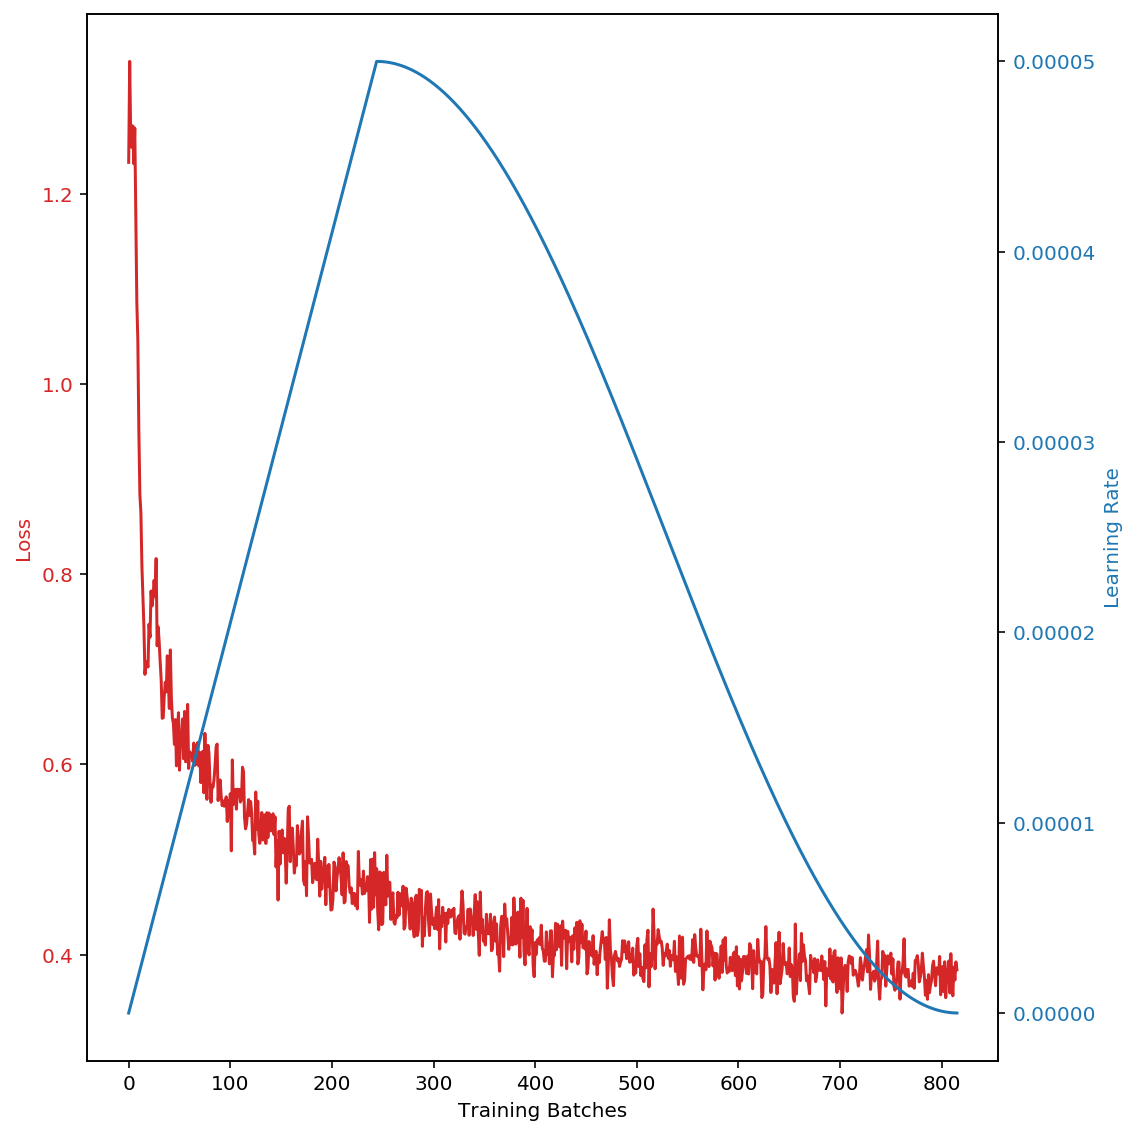

Proba       Preds    
         min   max   min max
Labels                      
0      0.019 0.684     0   1
1      0.081 0.755     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.511,"[0.4886881411075592, 0.5113118886947632]",1,0,0.535,"[0.4651243984699249, 0.5348756313323975]",1,1,0.372,"[0.6277286410331726, 0.3722713887691498]",0,1
1,0.481,"[0.5191325545310974, 0.4808674454689026]",0,0,0.517,"[0.4831622838973999, 0.5168377161026001]",1,1,0.302,"[0.6978563070297241, 0.30214372277259827]",0,0
2,0.450,"[0.549751877784729, 0.45024818181991577]",0,1,0.590,"[0.4097534716129303, 0.5902465581893921]",1,0,0.646,"[0.35366880893707275, 0.6463311910629272]",1,1
3,0.523,"[0.4773188531398773, 0.5226811170578003]",1,1,0.552,"[0.44833120703697205, 0.5516688227653503]",1,1,0.393,"[0.6072554588317871, 0.3927445411682129]",0,0
4,0.448,"[0.5519869923591614, 0.4480130076408386]",0,1,0.400,"[0.5997644662857056, 0.40023553371429443]",0,1,0.402,"[0.59769207239151, 0.4023078978061676]",0,0


scores =  {'map': '0.6249', 'acc': '0.5780', 'auc': '0.6549'}


train   val
mean_or_std metric               
mean        map       0.767 0.625
            accuracy  0.751 0.578
            auc       0.843 0.655
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.835  0.763 0.797 5450.000     0.560  0.724 0.632 250.000
pos     0.633  0.731 0.678 3050.000     0.610  0.432 0.506 250.000

In [15]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              gaussian_noise=0.1,
                              dropout=0.15,
                              word_masking_proba=0.15,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=3,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='./distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5,
                              attention_drop_proba=0.2,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# auc_loss_coef=0.5
# 0.853 0.661 (0.757 0.596) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,
# 0.852	0.658 (0.748	0.604) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.2,
# 0.857	0.661 (0.761	0.590) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.15,
# 0.845	0.657 (0.757	0.592) gaussian_noise=0.1, dropout=0.25, word_masking_proba=0.25,
# 0.841	0.644 (0.753	0.578) gaussian_noise=0.1, dropout=0.25, word_masking_proba=0.2,
# 0.861	0.647 (0.759	0.594) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.15,
# 0.857	0.652 (0.756	0.576) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.15,
# 0.848	0.661 (0.751	0.592) gaussian_noise=0.1, dropout=0.15, word_masking_proba=0.15,
# 0.853	0.657 (0.755	0.588) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,
# 0.853	0.661 (0.750	0.602) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,
# 0.852	0.649 (0.757	0.578) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,

# No reg_sched testing
# 0.848	0.652 (0.754	0.590) gaussian_noise=0.1, dropout=0.2, word_masking_proba=0.2,

# Cnn1D head


# Predict

In [12]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              gaussian_noise=0.1,
                              dropout=0.2,
                              word_masking_proba=0.2,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=3,
                              n_decoders=3,
                              n_tokens_in=96,
                              n_tokens_out=32,
                              featurizer="transformer",
                              model='./distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # decoder_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5,
                              attention_drop_proba=0.2,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


Autocast =  True Epochs =  48 Divisor = 2 Examples = 3050 Batch Size =  256
Training Samples =  6100 Weighted Sampling =  True Num Batches =  12 Accumulation steps =  1



Epoch =  1 Loss = 0.979856 LR = 0.00000001



Epoch =  2 Loss = 0.758919 LR = 0.00000001



Epoch =  3 Loss = 0.645848 LR = 0.00000002



Epoch =  4 Loss = 0.561513 LR = 0.00000003



Epoch =  5 Loss = 0.514693 LR = 0.00000003



Epoch =  6 Loss = 0.484570 LR = 0.00000004



Epoch =  7 Loss = 0.457672 LR = 0.00000005



Epoch =  8 Loss = 0.445202 LR = 0.00000006



Epoch =  9 Loss = 0.429538 LR = 0.00000006



Epoch =  10 Loss = 0.417026 LR = 0.00000007



Epoch =  11 Loss = 0.405561 LR = 0.00000008



Epoch =  12 Loss = 0.400622 LR = 0.00000008



Epoch =  13 Loss = 0.393892 LR = 0.00000009



Epoch =  14 Loss = 0.385446 LR = 0.00000010



Epoch =  15 Loss = 0.374409 LR = 0.00000010


Proba       Preds    
         min   max   min max
Labels                      
0      0.270 0.674     0   1
1      0.271 0.665     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.357,"[0.6433148384094238, 0.35668516159057617]",0,1,0.374,"[0.6262749433517456, 0.3737250864505768]",0,1,0.464,"[0.5364686846733093, 0.4635312855243683]",0,0
1,0.561,"[0.4388529658317566, 0.5611470937728882]",1,1,0.674,"[0.32643285393714905, 0.6735672354698181]",1,0,0.424,"[0.5763609409332275, 0.42363908886909485]",0,1
2,0.461,"[0.5391199588775635, 0.4608800709247589]",0,0,0.369,"[0.6311071515083313, 0.3688928484916687]",0,1,0.516,"[0.4844038486480713, 0.5155961513519287]",1,1
3,0.575,"[0.42491117119789124, 0.5750888586044312]",1,1,0.329,"[0.6708016991615295, 0.32919833064079285]",0,0,0.271,"[0.7285424470901489, 0.27145761251449585]",0,1
4,0.329,"[0.6708016991615295, 0.32919833064079285]",0,0,0.298,"[0.7019307017326355, 0.2980693578720093]",0,0,0.423,"[0.5770429372787476, 0.4229571521282196]",0,0


scores =  {'map': '0.5668', 'acc': '0.5540', 'auc': '0.5940'}
Epoch =  15 Train = 0.721553 Val = 0.594048



Epoch =  16 Loss = 0.366131 LR = 0.00000010



Epoch =  17 Loss = 0.361651 LR = 0.00000010



Epoch =  18 Loss = 0.356667 LR = 0.00000010



Epoch =  19 Loss = 0.357514 LR = 0.00000010



Epoch =  20 Loss = 0.348290 LR = 0.00000009



Epoch =  21 Loss = 0.346723 LR = 0.00000009



Epoch =  22 Loss = 0.341159 LR = 0.00000009



Epoch =  23 Loss = 0.337749 LR = 0.00000008



Epoch =  24 Loss = 0.334492 LR = 0.00000008



Epoch =  25 Loss = 0.332854 LR = 0.00000008



Epoch =  26 Loss = 0.339877 LR = 0.00000007



Epoch =  27 Loss = 0.334182 LR = 0.00000007



Epoch =  28 Loss = 0.327006 LR = 0.00000006



Epoch =  29 Loss = 0.325177 LR = 0.00000006



Epoch =  30 Loss = 0.329125 LR = 0.00000006



Epoch =  31 Loss = 0.326187 LR = 0.00000005


Proba       Preds    
         min   max   min max
Labels                      
0      0.072 0.570     0   1
1      0.141 0.580     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.213,"[0.7872404456138611, 0.2127595841884613]",0,0,0.422,"[0.5778605341911316, 0.4221394658088684]",0,0,0.415,"[0.5851396322250366, 0.41486039757728577]",0,0
1,0.494,"[0.5056682229042053, 0.49433183670043945]",0,1,0.481,"[0.5189900398254395, 0.48100998997688293]",0,1,0.420,"[0.5797954201698303, 0.42020466923713684]",0,0
2,0.475,"[0.5254788994789124, 0.47452113032341003]",0,0,0.354,"[0.6461704969406128, 0.353829562664032]",0,1,0.526,"[0.47382619976997375, 0.5261738896369934]",1,0
3,0.479,"[0.5214900970458984, 0.47850990295410156]",0,1,0.494,"[0.5063291192054749, 0.49367091059684753]",0,0,0.460,"[0.5399042367935181, 0.4600957930088043]",0,1
4,0.451,"[0.5491696000099182, 0.4508303701877594]",0,1,0.504,"[0.4956133961677551, 0.5043866038322449]",1,0,0.467,"[0.5325141549110413, 0.4674859046936035]",0,0


scores =  {'map': '0.6089', 'acc': '0.5460', 'auc': '0.6251'}
Epoch =  31 Train = 0.779935 Val = 0.625056



Epoch =  32 Loss = 0.325384 LR = 0.00000005



Epoch =  33 Loss = 0.318821 LR = 0.00000004



Epoch =  34 Loss = 0.322382 LR = 0.00000004


Proba       Preds    
         min   max   min max
Labels                      
0      0.095 0.609     0   1
1      0.157 0.626     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.508,"[0.4923440217971802, 0.5076559782028198]",1,1,0.329,"[0.6707705855369568, 0.3292294442653656]",0,1,0.517,"[0.4828476309776306, 0.5171523690223694]",1,1
1,0.487,"[0.5126412510871887, 0.48735880851745605]",0,1,0.530,"[0.4699740707874298, 0.5300258994102478]",1,0,0.378,"[0.6218031644821167, 0.3781968057155609]",0,0
2,0.506,"[0.49389776587486267, 0.5061022639274597]",1,0,0.455,"[0.5452865958213806, 0.45471349358558655]",0,0,0.285,"[0.7152751684188843, 0.2847249209880829]",0,0
3,0.384,"[0.6159346103668213, 0.3840654194355011]",0,0,0.600,"[0.4002881944179535, 0.5997118949890137]",1,0,0.439,"[0.5606936812400818, 0.4393063187599182]",0,0
4,0.115,"[0.8845508098602295, 0.1154492050409317]",0,0,0.503,"[0.49714961647987366, 0.5028504133224487]",1,0,0.381,"[0.6193755269050598, 0.3806244730949402]",0,1


scores =  {'map': '0.5891', 'acc': '0.5560', 'auc': '0.6111'}
Epoch =  34 Train = 0.780952 Val = 0.611096



Epoch =  35 Loss = 0.319285 LR = 0.00000003



Epoch =  36 Loss = 0.316662 LR = 0.00000003



Epoch =  37 Loss = 0.313579 LR = 0.00000002



Epoch =  38 Loss = 0.313909 LR = 0.00000002



Epoch =  39 Loss = 0.311739 LR = 0.00000002



Epoch =  40 Loss = 0.311923 LR = 0.00000001



Epoch =  41 Loss = 0.313768 LR = 0.00000001



Epoch =  42 Loss = 0.310999 LR = 0.00000001


Proba       Preds    
         min   max   min max
Labels                      
0      0.115 0.649     0   1
1      0.170 0.661     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.466,"[0.5343939065933228, 0.46560612320899963]",0,0,0.295,"[0.704501748085022, 0.2954983115196228]",0,1,0.461,"[0.5392455458641052, 0.4607544541358948]",0,1
1,0.505,"[0.49506014585494995, 0.5049399137496948]",1,1,0.543,"[0.4572490453720093, 0.5427509546279907]",1,0,0.519,"[0.4810548722743988, 0.5189451575279236]",1,0
2,0.515,"[0.4845357835292816, 0.5154642462730408]",1,1,0.356,"[0.6441943645477295, 0.35580572485923767]",0,0,0.324,"[0.675918459892273, 0.32408156991004944]",0,0
3,0.569,"[0.4310528337955475, 0.5689471960067749]",1,0,0.584,"[0.415558397769928, 0.5844416618347168]",1,0,0.520,"[0.47958993911743164, 0.5204100608825684]",1,0
4,0.506,"[0.4940480589866638, 0.505952000617981]",1,1,0.568,"[0.43249645829200745, 0.5675035119056702]",1,1,0.440,"[0.5595294237136841, 0.4404706060886383]",0,0


scores =  {'map': '0.5890', 'acc': '0.5800', 'auc': '0.6182'}
Epoch =  42 Train = 0.789715 Val = 0.618168



Epoch =  43 Loss = 0.310799 LR = 0.00000001



Epoch =  44 Loss = 0.312568 LR = 0.00000000



Epoch =  45 Loss = 0.305018 LR = 0.00000000



Epoch =  46 Loss = 0.307765 LR = 0.00000000



Epoch =  47 Loss = 0.312203 LR = 0.00000000



Epoch =  48 Loss = 0.307219 LR = 0.00000000



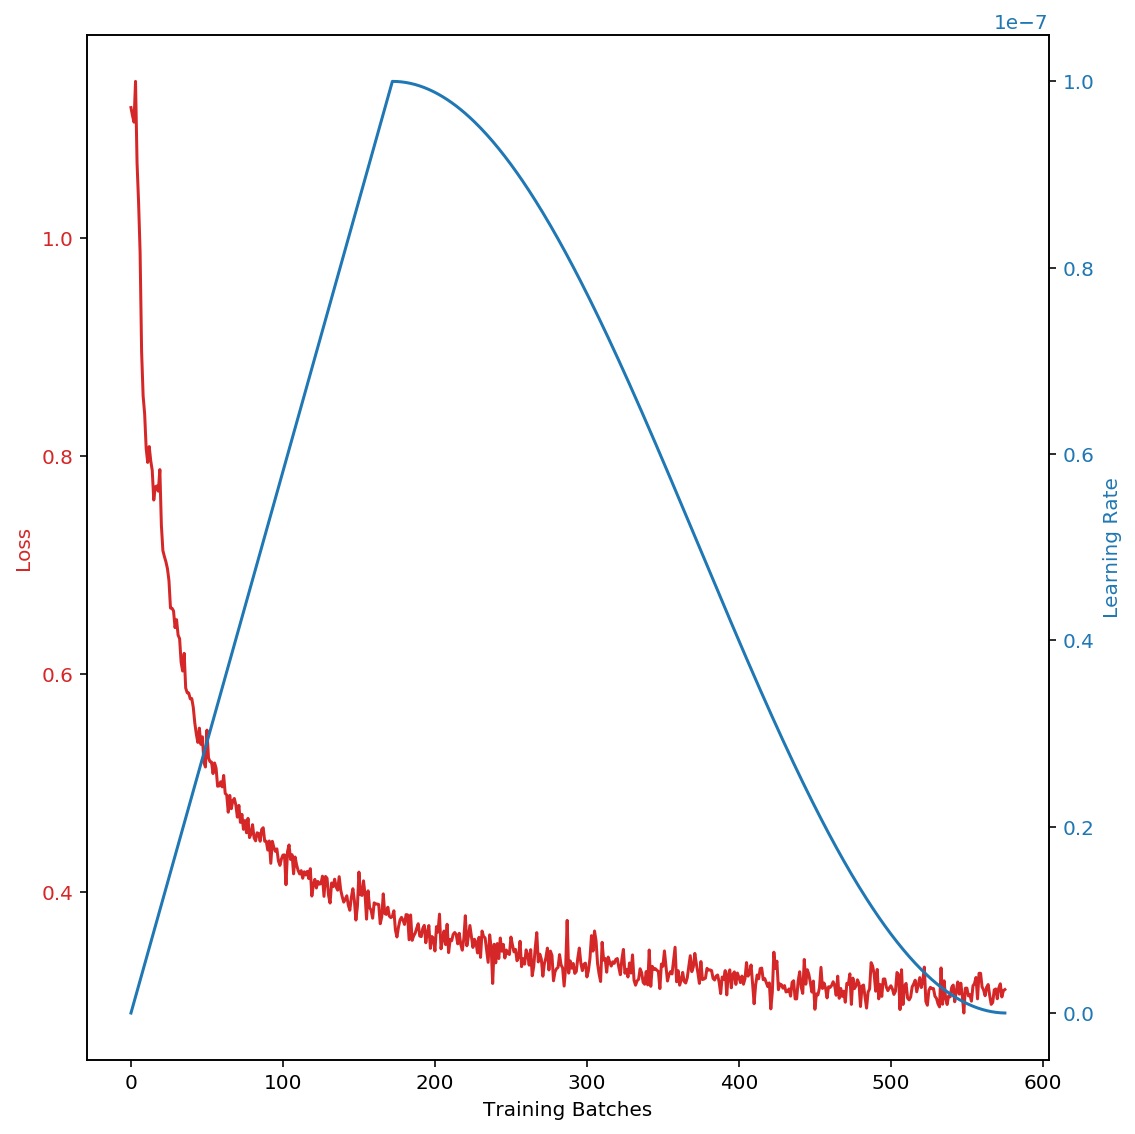

,id,proba,label
522,78956,0.548,1
357,91637,0.578,1
604,68172,0.571,1
100,49267,0.522,1
776,63097,0.193,0


In [13]:
submission, text_model = train_and_predict(model_fn, data, batch_size, epochs, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched,
                                           sampling_policy="without_replacement",
                                           validation_epochs=[15, 31, 34, 42],
                                          )
submission.to_csv("submission.csv",index=False)
submission.sample(5)
